In [1]:
#cálculo numérico y análisis de datos
import numpy as np
import graphviz
from graphviz import Digraph
#manipulación y análisis de datos (estructuras de datos)
import pandas as pd
labels = ['Pelo', 'Altura', 'Peso', 'Proteccion', 'Quemadura']
quemadura_data = pd.read_csv("arbQuemadura.csv", index_col=0)
quemadura_data.head()

,Pelo,Altura,Peso,Proteccion,Quemadura
Ejemplo,,,,,
1,rubio,medio,bajo,no,si
2,rubio,alto,medio,si,no
3,moreno,bajo,medio,si,no
4,rubio,bajo,medio,no,si
5,rojo,medio,alto,no,si


### calcular la entropia

In [2]:
def calcular_entropia(p):
    return -np.sum(p*np.log2(p))

### calcular la ganancia

In [4]:
#calcular la ganancia
def calcular_ganancia(valores, var='Pelo'):
    valores, cuantos = np.unique(quemadura_data[var],return_counts=True)
    #genero una lista para calcular la ganancia
    info_A = []
    
    for e in valores:
        se = np.where(quemadura_data[var]==e)
        #print("tiene se",se)
        #particiona por valor
        se_quemadura = quemadura_data['Quemadura'][quemadura_data.index[se[0]]]
        #print("se_quemadura",se_quemadura)
        #valores por subgrupo
        v_se_quemadura, c_se_quemadura = np.unique(se_quemadura,return_counts=True)
        print("subgrupos ",v_se_quemadura,c_se_quemadura)
        #entropia del valor
        se_entropia = abs(calcular_entropia(c_se_quemadura/sum(c_se_quemadura)))
        print("Entropia: ",se_entropia)
        #probabilidad del valor
        se_size = sum(c_se_quemadura)/len(quemadura_data.index)
        #print("probabilidad valor",se_size)
        #almacenar valores
        info_A += [[se_entropia, se_size]]
        print("info_A",info_A)
    #convertir lista en arreglo
    info_A = np.array(info_A)
    #calcular la entropia de la variable
    info_g = np.sum(info_A[:,0]*info_A[:,1])
    print("info_g",info_g)
    return info_g

## Calcular la entropia del arbol

In [3]:
valores, cuantos = np.unique(quemadura_data['Quemadura'], return_counts=True)
entropia = calcular_entropia(cuantos/sum(cuantos))
print("Entropia del arbol",entropia)
valores,cuantos

Entropia del arbol 0.954434002924965


(array(['no', 'si'], dtype=object), array([5, 3], dtype=int64))

subgrupos  ['no'] [3]
Entropia:  0.0
info_A [[0.0, 0.375]]
subgrupos  ['si'] [1]
Entropia:  0.0
info_A [[0.0, 0.375], [0.0, 0.125]]
subgrupos  ['no' 'si'] [2 2]
Entropia:  1.0
info_A [[0.0, 0.375], [0.0, 0.125], [1.0, 0.5]]
info_g 0.5
ganancia de Pelo
************Pelo************
subgrupos  ['no'] [2]
Entropia:  0.0
info_A [[0.0, 0.25]]
subgrupos  ['no' 'si'] [2 1]
Entropia:  0.9182958340544896
info_A [[0.0, 0.25], [0.9182958340544896, 0.375]]
subgrupos  ['no' 'si'] [1 2]
Entropia:  0.9182958340544896
info_A [[0.0, 0.25], [0.9182958340544896, 0.375], [0.9182958340544896, 0.375]]
info_g 0.6887218755408672
ganancia de Altura
************Altura************
subgrupos  ['no' 'si'] [2 1]
Entropia:  0.9182958340544896
info_A [[0.9182958340544896, 0.375]]
subgrupos  ['no' 'si'] [1 1]
Entropia:  1.0
info_A [[0.9182958340544896, 0.375], [1.0, 0.25]]
subgrupos  ['no' 'si'] [2 1]
Entropia:  0.9182958340544896
info_A [[0.9182958340544896, 0.375], [1.0, 0.25], [0.9182958340544896, 0.375]]
info_g 0.9

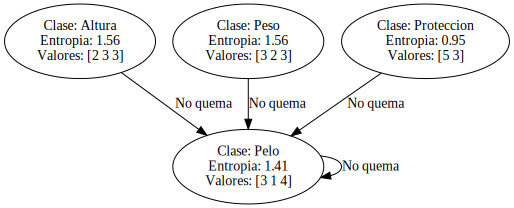

In [14]:
g = Digraph('grafo')
clase = ['Quema', 'No quema']
for lab in labels[0:4]:
    valores, cuantos = np.unique(quemadura_data[lab], return_counts=True)
    entropia = calcular_entropia(cuantos/sum(cuantos))
    valores,cuantos
    info_A= calcular_ganancia(valores, lab)
    ganancia = entropia - info_A
    print("ganancia de {}".format(lab))
    print('************{}************'.format(lab))
    g.node(lab, label='Clase: {} \\n Entropia: {} \\n Valores: {}'.format(lab, round(entropia, 2), cuantos))
    lb = clase[0] if entropia == 0 else clase[1]
    g.edge(lab, labels[0], label=lb)
g

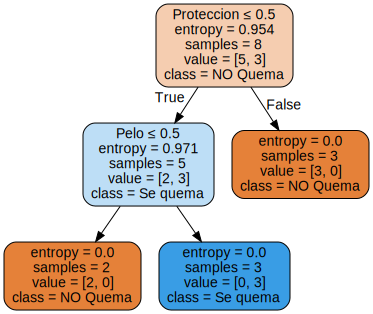

In [6]:
#utilizando la librería sklearn

from sklearn import tree
from sklearn import preprocessing

data = pd.DataFrame()
le = preprocessing.LabelEncoder()
var = ["Pelo","Altura","Peso","Proteccion","Quemadura"]

for v in var:
    le.fit(quemadura_data[v])
    data[v] = le.transform(quemadura_data[v])
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
t_data = data[data.columns[0:4]]
t_target = data[data.columns[4]]
clf = clf.fit(t_data, t_target)
t_data, t_target,clf
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=list(t_data.columns.values),
                         class_names=["NO Quema", "Se quema"],
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph